In [8]:
import collections
import copy
import itertools

import cvrplib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import numpy.random as rnd

from alns import ALNS, State
from alns.accept import SimulatedAnnealing, RecordToRecordTravel, HillClimbing
from alns.stop import MaxRuntime, MaxIterations
from alns.select import RouletteWheel

In [9]:
%matplotlib inline

In [10]:
SEED = 1234
rnd_state = rnd.RandomState(SEED)

# The capacitated vehicle routing problem
The vehicle routing problem (VRP) is one of the most studied problems in operations research. Given a fleet of vehicles and customers, the goal is to construct a set of routes such that each customer is visited exactly once, while minimizing the total distance traveled by the vehicles. 

Despite the decades long research, the VRP (and variants thereof) remains a very hard problem to solve and new algorithms continue to be developed to tackle this problem. A related and interesting fact is that ALNS was originally proposed by [Ropke and Pisinger (2006)](https://pubsonline.informs.org/doi/abs/10.1287/trsc.1050.0135?casa_token=-DeLGU-Nr_4AAAAA:hTPxhhAn8TRi5h8p5LdQ_r-tQ1j4lCD4-K4ZR4gSi0e9O6reL6vcyfC0NZmkW1hoQGkUEjcumwH6) to solve many variants of the vehicle routing problem. 

In this notebook, we use ALNS to solve the most famous VRP variant: the *Capacitated Vehicle Routing Problem (CVRP)*. The CVRP can be described using an undirected graph $G=(V,E)$, where $V$ is the vertex set and $E$ is the edge set. The vertex set $V$ is partitioned into $V=\{0\} \cup V_c$, where $0$ is the depot and $V_c=\{1, \dots, n\}$ denotes the set of $n$ customers. Each customer $i \in V_c$ has a demand $q_i > 0$. A distance $d_{ij}$ is associated with each edge $(i, j) \in E$. We assume that we have an unlimited fleet of homogeneous vehicles with capacity $Q$ located at the depot. A feasible solution to the CVRP is a set of routes, each served by a single vehicle, such that each customer is served exactly once and none of the routes exceed the vehicle capacity. The goal is to minimize the total distance traveled.

## Data
[CVRPLIB](http://vrp.atd-lab.inf.puc-rio.br/index.php/en/) contains a large collection of CVRP benchmark instances. The library is actively maintained and new best known solutions are updated regularly. We will make use of the `cvrplib` package to download the `D/ORTEC-n242-k12` instance, which consists of 241 customers (+ 1 depot) and 12 vehicles.

In [11]:
data, bks = cvrplib.download('ORTEC-n242-k12', solution=True)

The `bks` variable contains the best known solution. Let's plot it, together with the coordinates of the customers:

In [12]:
def plot_solution(solution, name="CVRP solution"):
    """
    Plot the routes of the passed-in solution.
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    cmap = matplotlib.cm.rainbow(np.linspace(0, 1, len(solution.routes)))

    for idx, route in enumerate(solution.routes):
        ax.plot(
            [data.coordinates[loc][0] for loc in [0] + route + [0]],
            [data.coordinates[loc][1] for loc in [0] + route + [0]],
            color=cmap[idx],
            marker='.',
        )

    ax.set_title(f"{name}\n Total distance: {solution.cost}")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")

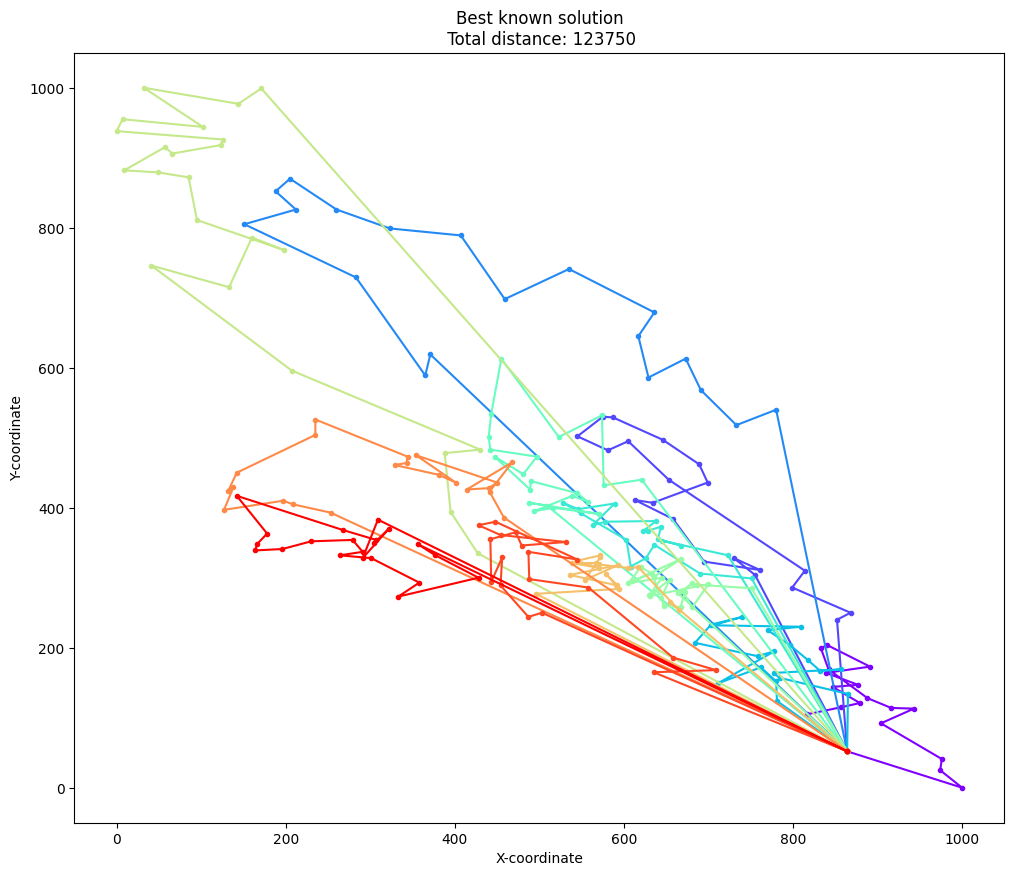

In [13]:
plot_solution(bks, name="Best known solution")

## Solution state

In [14]:
class CvrpState(State):
    """
    Solution state for CVRP. It has two data members, routes and unassigned.
    Routes is a list of list of integers, where each inner list corresponds to
    a single route denoting the sequence of customers to be visited. A route
    does not contain the start and end depot. Unassigned is a list of integers, 
    each integer representing an unassigned customer.
    """

    def __init__(self, routes, unassigned=None):
        self.routes = routes
        self.unassigned = unassigned if unassigned is not None else []

    def copy(self):
        """
        Helper method to ensure each solution state is immutable.
        """
        return CvrpState(copy.deepcopy(self.routes),
                        self.unassigned.copy())

    def objective(self):
        """
        Computes the total route costs.
        """
        return sum(route_cost(route) for route in self.routes)
    
    @property
    def cost(self):
        """
        Alias for objective method.
        """
        return self.objective()

    def find_route(self, customer):
        """
        Return the route that contains the passed-in customer.
        """
        for route in self.routes:
            if customer in route:
                return route

        raise ValueError(f"Solution does not contain customer {customer}.")
        
def route_cost(route):
    tour = [0] + route + [0]
    return sum(data.distances[tour[idx]][tour[idx+1]] for idx in range(len(tour) - 1))

## Destroy operators

Destroy operators break parts of a solution down, leaving an incomplete state. This is the first part of each iteration of the ALNS meta-heuristic; the incomplete solution is subsequently repaired by any one repair operator. We will consider one destroy operator: **random removal**. We will also use a separate parameter, the degree of destruction, to control the extent of the damage done to a solution in each step.

In [15]:
degree_of_destruction = 0.05
customers_to_remove = int((data.dimension - 1) * degree_of_destruction)

In [16]:
def random_removal(state, rnd_state):
    """
    Removes a number of randomly selected customers from the passed-in solution.
    """
    destroyed = state.copy()

    for customer in rnd_state.choice(range(1, data.dimension), customers_to_remove, replace=False):
        destroyed.unassigned.append(customer)

        for route in destroyed.routes:
            if customer in route:
                route.remove(customer)
                break

    return remove_empty_routes(destroyed)


def remove_empty_routes(state):
    """
    Remove empty routes after applying the destroy operator.
    """
    state.routes = [route for route in state.routes if len(route) != 0]
    return state

## Repair operators
We implement a simple, **greedy repair** strategy. It iterates over the set of unassigned customers and finds the best route and index to insert to, i.e., with the least increase in cost.

In [17]:
def greedy_repair(state, rnd_state):
    """
    Inserts the unassigned customers in the best route. If there are no
    feasible insertions, then a new route is created.
    """
    rnd_state.shuffle(state.unassigned)

    while len(state.unassigned) != 0:
        customer = state.unassigned.pop()
        route, idx = best_insert(customer, state)

        if route is not None:
            route.insert(idx, customer)
        else:
            state.routes.append([customer])

    return state


def best_insert(customer, state):
    """
    Finds the best feasible route and insertion idx for the customer.
    Return (None, None) if no feasible route insertions are found.
    """
    best_cost, best_route, best_idx = None, None, None

    for route in state.routes:
        for idx in range(len(route) + 1):

            if can_insert(customer, route):
                cost = insert_cost(customer, route, idx)

                if best_cost is None or cost < best_cost:
                    best_cost, best_route, best_idx = cost, route, idx

    return best_route, best_idx


def can_insert(customer, route):
    """
    Checks if inserting customer does not exceed vehicle capacity.
    """
    total = sum(data.demands[cust] for cust in route) + data.demands[customer]
    return total <= data.capacity


def insert_cost(customer, route, idx):
    """
    Computes the insertion cost for inserting customer in route at idx.
    """
    pred = 0 if idx == 0 else route[idx - 1]
    succ = 0 if idx == len(route) else route[idx]

    # Increase in cost by adding the customer
    cost = data.distances[pred][customer] + data.distances[customer][succ]

    # Decrease in cost by removing old edge (pred, succ)
    cost -= data.distances[pred][succ]

    return cost

## Initial solution
We need an initial solution that is going to be destroyed and repaired by the ALNS heuristic. To this end, we use a simple *nearest neighbor (NN)* heuristic. NN starts with an empty solution and iteratively adds the nearest customer to the routes. If there are no routes available, then a new route is created.

In [18]:
def neighbors(customer):
    """
    Return the nearest neighbors of the customer, excluding the depot.
    """
    locations = np.argsort(data.distances[customer])
    return locations[locations != 0]


def nearest_neighbor():
    """
    Build a solution by iteratively constructing routes, where the nearest
    customer is added until the route has met the vehicle capacity limit.
    """
    routes = []
    unvisited = list(range(1, data.dimension))

    while unvisited:
        route = [0]  # Start at the depot
        route_demands = 0

        while unvisited:
            # Add the nearest unvisited customer to the route till max capacity
            current = route[-1]
            nearest = [nb for nb in neighbors(current) if nb in unvisited][0]

            if route_demands + data.demands[nearest] > data.capacity:
                break

            route.append(nearest)
            unvisited.remove(nearest)
            route_demands += data.demands[nearest]

        customers = route[1:]  # Remove the depot
        routes.append(customers)

    return CvrpState(routes)

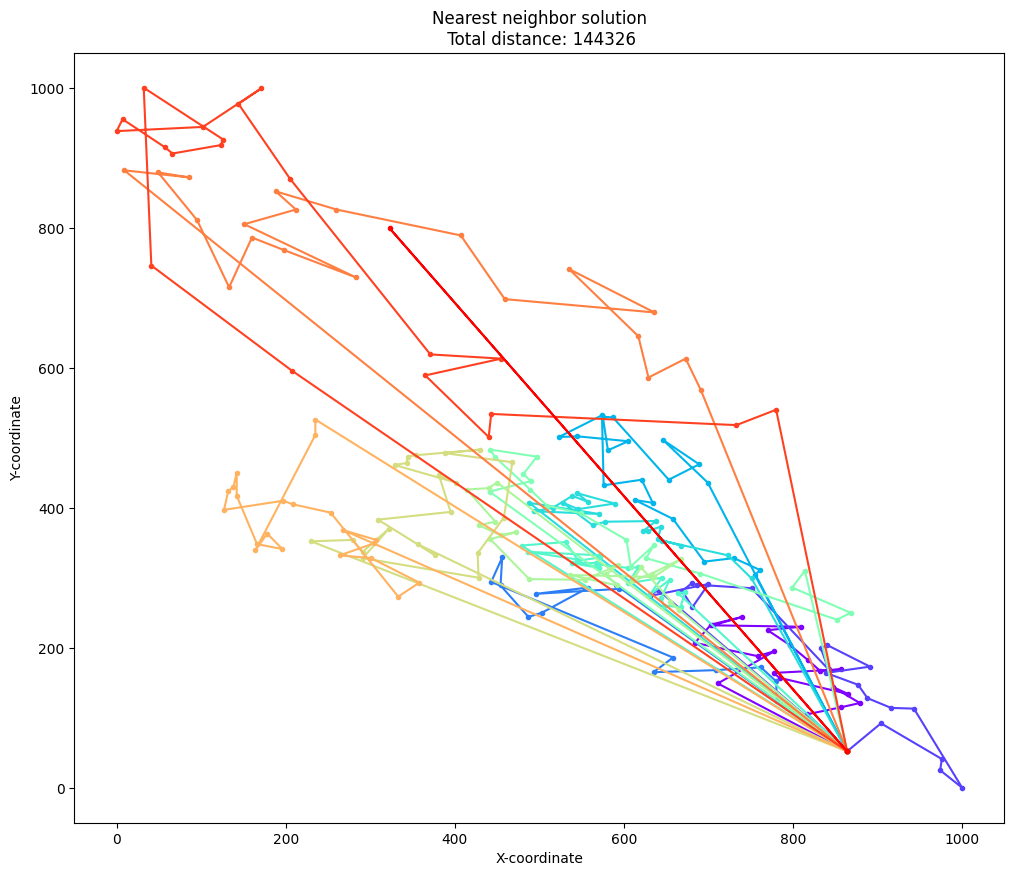

In [19]:
initial = nearest_neighbor()
plot_solution(initial, 'Nearest neighbor solution')

## Heuristic solution
Let's now construct our ALNS heuristic. Since we only have one destroy and repair operator, we actually don't use the adaptive part (i.e., operator selection), but you can easily add more destroy/repair operators. 

In [20]:
alns = ALNS(rnd_state)

alns.add_destroy_operator(random_removal)

alns.add_repair_operator(greedy_repair)

In [22]:
crit = HillClimbing()
weights = RouletteWheel([25, 5, 1, 0], 1, 1, 0.8)
stop = MaxRuntime(60)

result = alns.iterate(initial, weights, crit, stop)

In [23]:
solution = result.best_state
objective = solution.objective()
pct_difference = 100 * (objective - bks.cost) / bks.cost

print(f"Best heuristic objective is {objective}.")
print(f"This is {pct_difference:.1f}% worse than the optimal solution, which is {bks.cost}.")

Best heuristic objective is 131424.
This is 6.2% worse than the optimal solution, which is 123750.


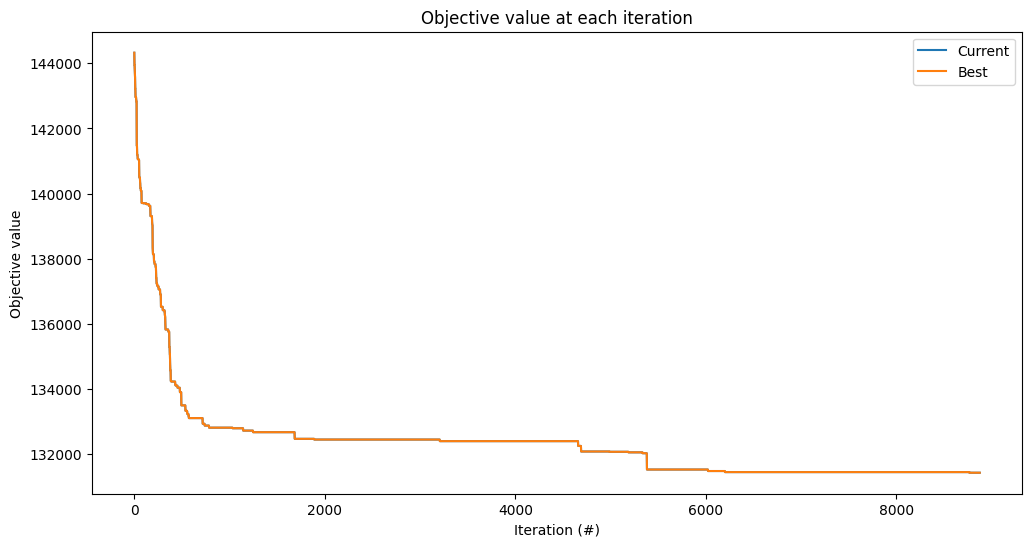

In [24]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax)

Let's have a look at the solution:

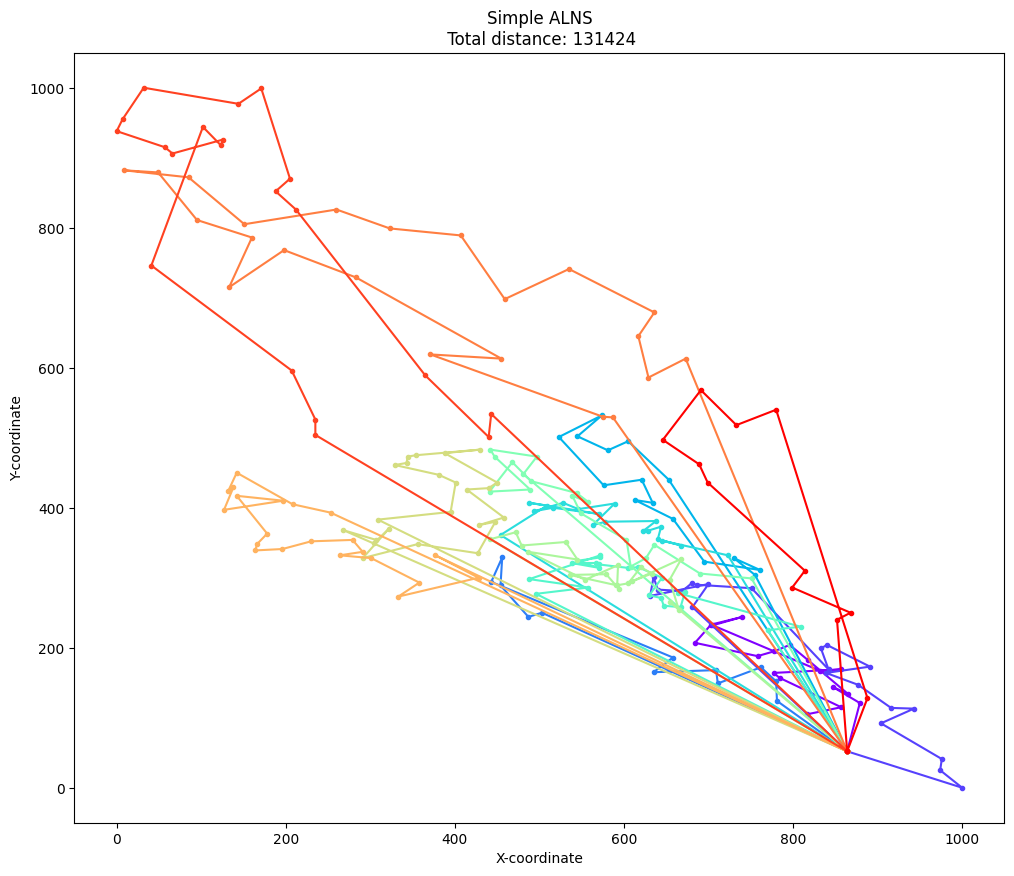

In [25]:
plot_solution(solution, 'Simple ALNS')

## Slack-induced substring removal
The simple destroy and repair operator from above work fine, but there are better destroy and repair operators for CVRP. One example is the *Slack Induction by Substring Removal (SISR)* method proposed by [Christiaens and Vanden Berghe (2020)](https://pubsonline.informs.org/doi/abs/10.1287/trsc.2019.0914?casa_token=lPUXU1Ax8PIAAAAA:yTE9Pu6L9QGPRu_vt-ZMHF0AZvL9gV0fNS4QAUTOJboQcgTVyOR9_RTbm9rZcImyKI4GUW9pLv1j). SISR obtains state-of-the-art results using a destroy operator that, instead of removing random customers, removes partial routes (called *strings*) that are all located near each other. Moreover, a blinking feature is added to the greedy repair operator, where certain insertion checks are skipped. For more details, we refer to the paper.

In the following, we will implement a simplified version of the string removal operator and replace the random destroy operator.

In [26]:
MAX_STRING_REMOVALS = 2
MAX_STRING_SIZE = 12

def string_removal(state, rnd_state):
    """
    Remove partial routes around a randomly chosen customer.
    """
    destroyed = state.copy()

    avg_route_size = int(np.mean([len(route) for route in state.routes]))
    max_string_size = max(MAX_STRING_SIZE, avg_route_size)
    max_string_removals = min(len(state.routes), MAX_STRING_REMOVALS)

    destroyed_routes = []
    center = rnd_state.randint(1, data.dimension)

    for customer in neighbors(center):
        if len(destroyed_routes) >= max_string_removals:
            break

        if customer in destroyed.unassigned:
            continue

        route = destroyed.find_route(customer)
        if route in destroyed_routes:
            continue

        customers = remove_string(route, customer, max_string_size, rnd_state)
        destroyed.unassigned.extend(customers)
        destroyed_routes.append(route)

    return destroyed


def remove_string(route, cust, max_string_size, rnd_state):
    """
    Remove a string that constains the passed-in customer.
    """
    # Find consecutive indices to remove that contain the customer
    size = rnd_state.randint(1, min(len(route), max_string_size) + 1)
    start = route.index(cust) - rnd_state.randint(size)
    idcs = [idx % len(route) for idx in range(start, start + size)]

    # Remove indices in descending order
    removed_customers = []
    for idx in sorted(idcs, reverse=True):
        removed_customers.append(route.pop(idx))

    return removed_customers

In [27]:
alns = ALNS(rnd_state)

alns.add_destroy_operator(string_removal)

alns.add_repair_operator(greedy_repair)

In [29]:
initial = nearest_neighbor()
criterion = HillClimbing()
weights = RouletteWheel([25, 5, 1, 0], 1, 1, 0.8)
stop = MaxRuntime(60)

result = alns.iterate(initial, weights, criterion, stop)

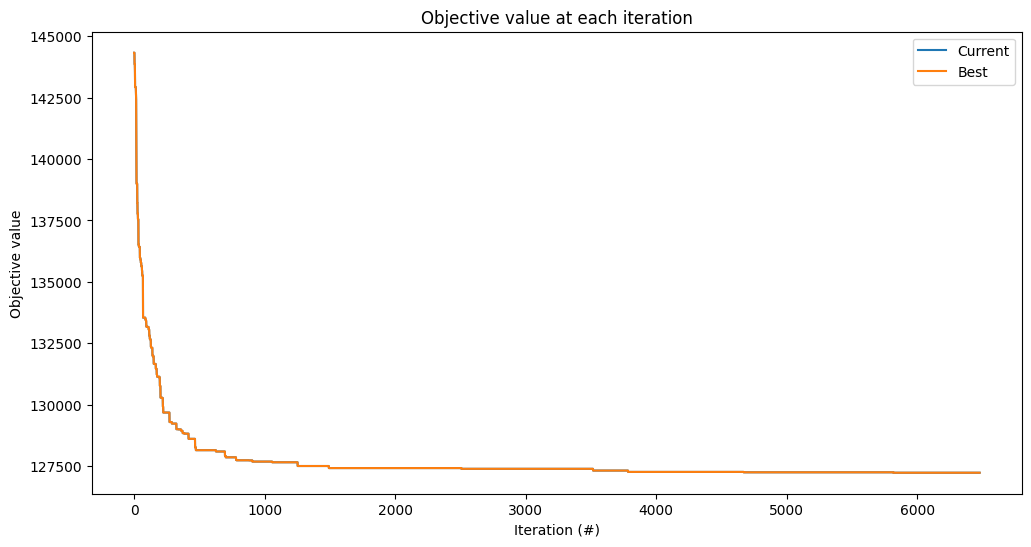

In [30]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax)

Best heuristic objective is 127233.
This is 2.8% worse than the optimal solution, which is 123750.


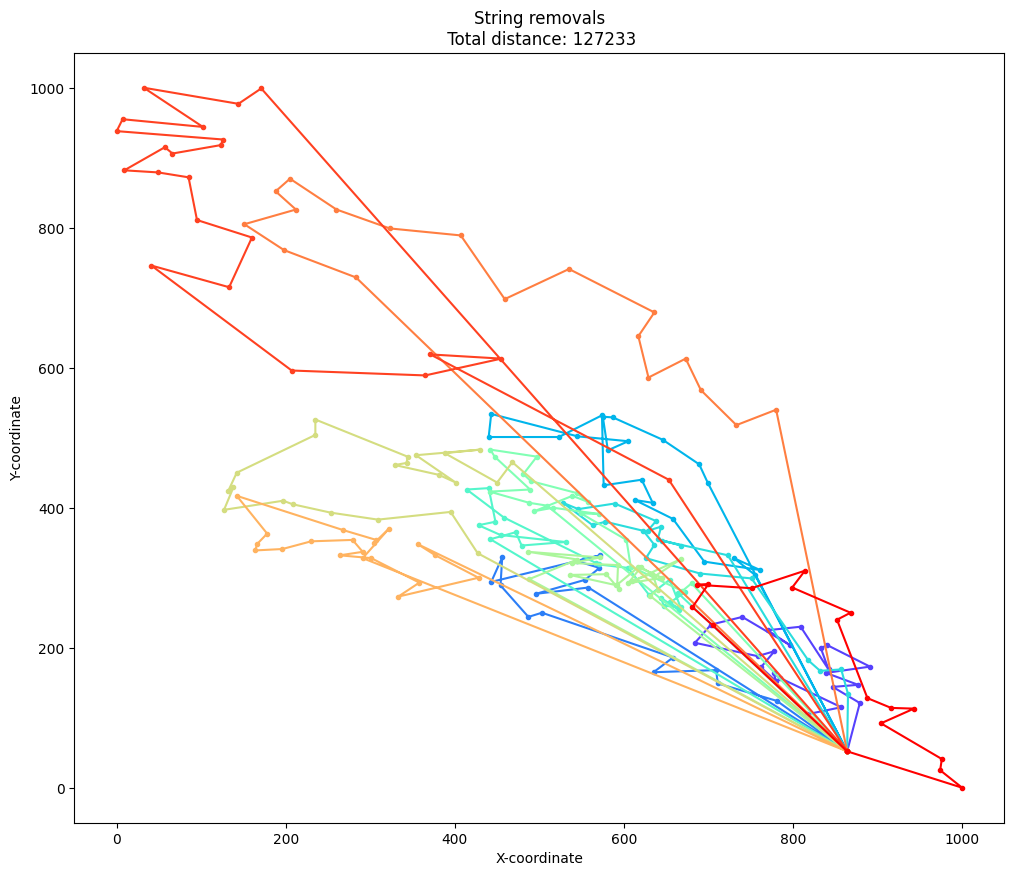

In [31]:
solution = result.best_state
objective = solution.objective()
pct_difference = 100 * (objective - bks.cost) / bks.cost

print(f"Best heuristic objective is {objective}.")
print(f"This is {pct_difference:.1f}% worse than the optimal solution, which is {bks.cost}.")
plot_solution(solution, 'String removals')

# Conclusions

In this notebook we implemented two heuristics for the CVRP, using the ALNS meta-heuristic framework. The first heuristic used a random customer removal operator and we obtained a solution which is 6.2% from the best known solution. The second heuristic used a removal operator by removing strings arround a randomly selected customer, which yielded a solution that is only 2.8% from the best known solution. 

This example shows that by constructing problem-specific operators, one can create even more powerful ALNS heuristics.